In [ ]:
import os
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display
from datasets import load_dataset
import os
import pandas as pd 

from byaldi import RAGMultiModalModel

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

In [ ]:
with open('hf_key.txt', 'r') as file:
    hf_key = file.read().strip()

with open("openai_api_key.txt", "r") as file:
    openai_key = file.read().strip()

os.environ["HF_TOKEN"] = hf_key
os.environ["OPENAI_API_KEY"] = openai_key

In [ ]:
import warnings

warnings.filterwarnings('ignore')

## Dataset 

In [ ]:
# Load the dataset
dataset = load_dataset("ibm/finqa", trust_remote_code=True)

# Access the splits
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

In [ ]:
train_data = pd.DataFrame(train_data)
train_data.set_index('id', inplace=True)
train_data = train_data[["question", "answer"]]

In [ ]:
train_data["Company"] = [row[0] for row in train_data.index.str.split("/")]
train_data["Year"] = [row[1] for row in train_data.index.str.split("/")]
train_data.head(5)

In [23]:
example = train_data.iloc[3]
example

question    what percentage of total cash and investments ...
answer                                                    53%
Company                                                  INTC
Year                                                     2013
Name: INTC/2013/page_71.pdf-4, dtype: object

## Indexing 

In [ ]:
try:
    RAG = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0", device="mps")
    RAG.index(
        input_path="docs/INTC/2013/", # The path to your documents
        index_name="test", # The name you want to give to your index. It'll be saved at `index_root/index_name/`.
        store_collection_with_index=True, # Whether the index should store the base64 encoded documents.
        overwrite=True # Whether to overwrite an index if it already exists. If False, it'll return None and do nothing if `index_root/index_name` exists.
    )
except Exception as e:
    RAG.from_index("test", device="mps")

In [25]:
query = example["question"]

results = RAG.search(query, k=3)

query = "Give a very short answer a single number or a few words to the following question:" + " " + query + "\n" + "Then explain your reasoning in a few sentences."

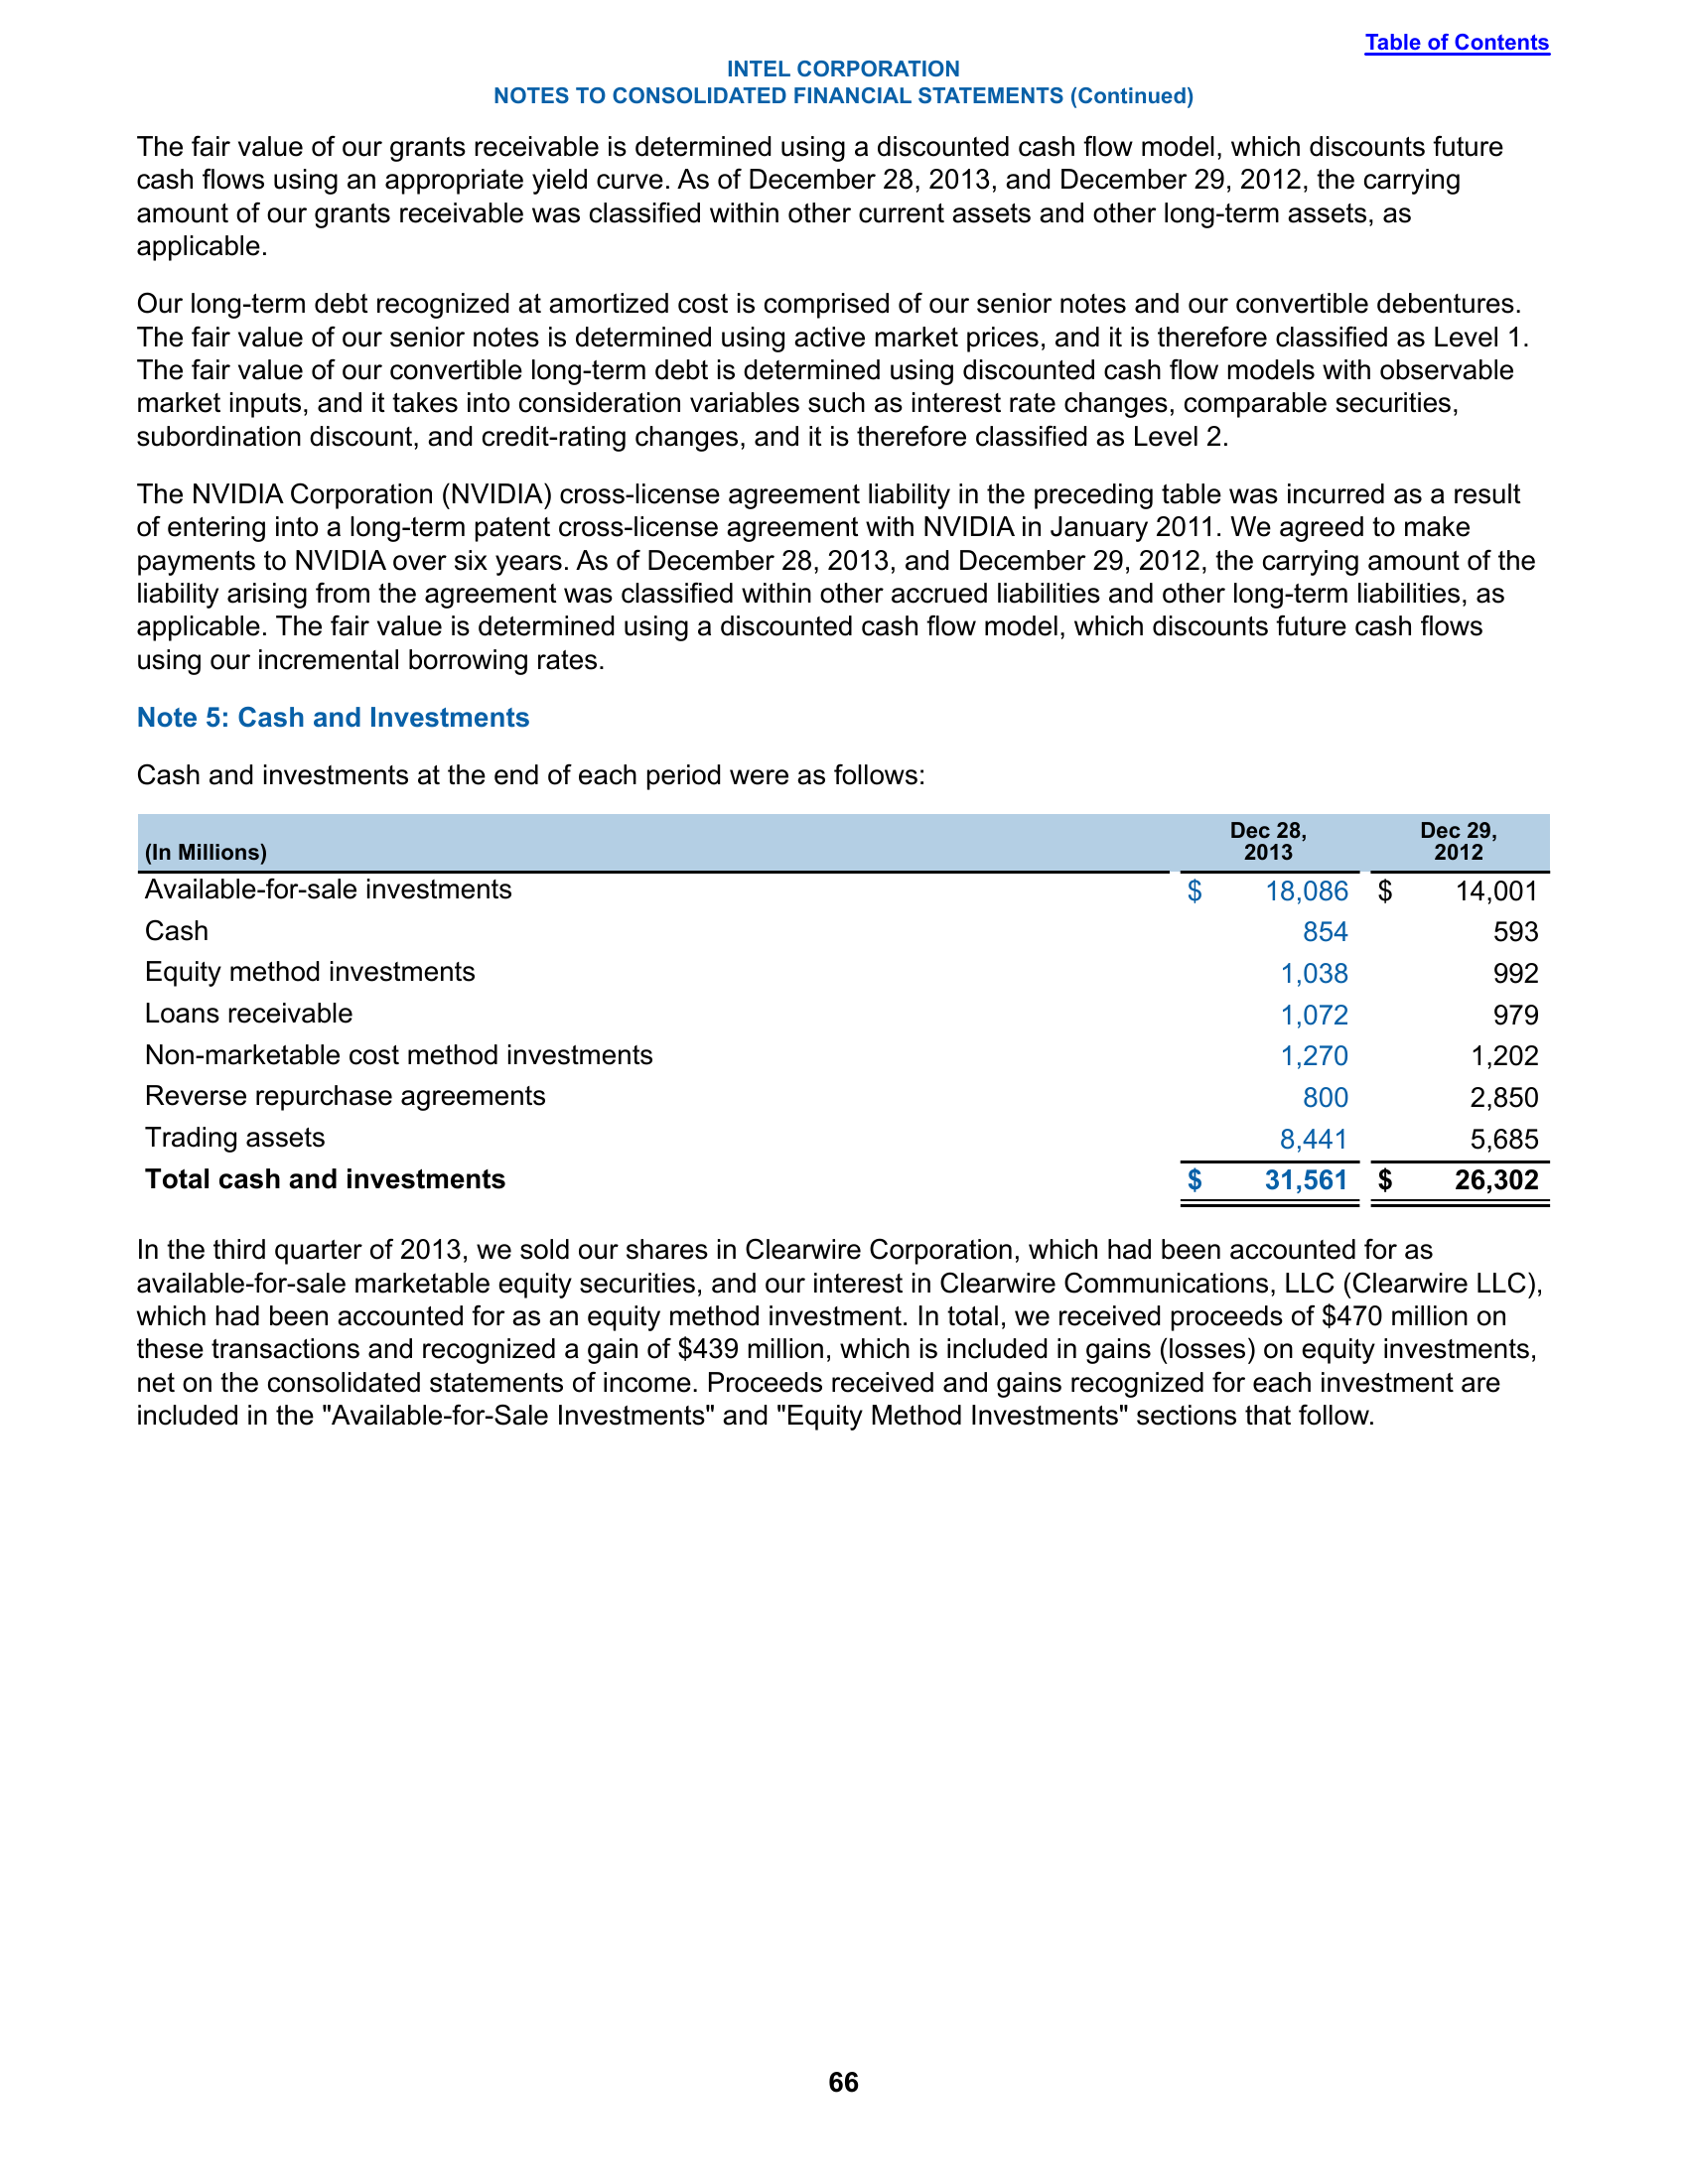

In [26]:
# Decode the base64 string
image_data = base64.b64decode(results[0]['base64'])

# Convert the bytes to an image
image = Image.open(BytesIO(image_data))

# Display the image in the notebook
display(image)

In [30]:
model = ChatOpenAI(model="gpt-4o")

In [31]:
message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/pdf;base64,{results[0]['base64']}"},
        },
    ],
)

response = model.invoke([message])

In [32]:
response.content

'53.2%\n\n**Reasoning:**\n\n1. Total cash and investments as of December 29, 2012, was $26,302 million.\n2. Available-for-sale investments as of the same date were $13,975 million.\n3. The percentage is calculated as: \\((13,975 / 26,302) \\times 100 \\approx 53.2\\%\\).'